# Classify a Raster Using Threshold Values

In this tutorial, we will learn how to:
1. Read NEON LiDAR Raster Geotifs (eg. CHM, Slope Aspect) into Python numpy arrays with gdal.
2. Create a classified raster object.

First, let's import the required packages and set our plot display to be in line:

In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Open a Geotif with GDAL

Let's look at the SERC Canopy Height Model (CHM) to start. We can open and read this in Python using the ```gdal.Open``` function:

In [2]:
chm_filename = '../data/SERC/lidar/2016_SERC_1_367000_4306000_pit_free_CHM.tif'
chm_dataset = gdal.Open(chm_filename)

### Read information from Geotif Tags
The Geotif file format comes with associated metadata containing information about the location and coordinate system/projection. Once we have read in the dataset, we can access this information with the following commands: 

In [3]:
#Display the dataset dimensions, number of bands, driver, and geotransform 
cols = chm_dataset.RasterXSize; print('# of columns:',cols)
rows = chm_dataset.RasterYSize; print('# of rows:',rows)
print('# of bands:',chm_dataset.RasterCount)
print('driver:',chm_dataset.GetDriver().LongName)

# of columns: 1000
# of rows: 1000
# of bands: 1
driver: GeoTIFF


### ```GetProjection``` 
We can use ```GetProjection``` to see information about the coordinate system and EPSG code. 

In [4]:
print('projection:',chm_dataset.GetProjection())

projection: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32618"]]


### ```GetGeoTransform```

The geotransform contains information about the origin (upper-left corner) of the raster, the pixel size, and the rotation angle of the data. All NEON data in the latest format have zero rotation. In this example, the values correspond to: 

In [5]:
print('geotransform:',chm_dataset.GetGeoTransform())

geotransform: (367000.0, 1.0, 0.0, 4307000.0, 0.0, -1.0)


In this case, the geotransform values correspond to:

1. Left-Most X Coordinate = `367000.0`
2. W-E Pixel Resolution = `1.0`
3. Rotation (0 if Image is North-Up) = `0.0`
4. Upper Y Coordinate = `4307000.0`
5. Rotation (0 if Image is North-Up) = `0.0`
6. N-S Pixel Resolution = `-1.0` 

We can convert this information into a spatial extent (xMin, xMax, yMin, yMax) by combining information about the origin, number of columns & rows, and pixel size, as follows:

In [6]:
chm_mapinfo = chm_dataset.GetGeoTransform()
xMin = chm_mapinfo[0]
yMax = chm_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/chm_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/chm_mapinfo[5] #divide by pixel height (note sign +/-)
chm_ext = (xMin,xMax,yMin,yMax)
print('chm raster extent:',chm_ext)

chm raster extent: (367000.0, 368000.0, 4306000.0, 4307000.0)


### ```GetRasterBand``` 
We can read in a single raster band with ```GetRasterBand``` and access information about this raster band such as the No Data Value, Scale Factor, and Statitiscs as follows:

In [7]:
chm_raster = chm_dataset.GetRasterBand(1)
noDataVal = chm_raster.GetNoDataValue(); print('no data value:',noDataVal)
scaleFactor = chm_raster.GetScale(); print('scale factor:',scaleFactor)
chm_stats = chm_raster.GetStatistics(True,True)
print('SERC CHM Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (chm_stats[0], chm_stats[1], chm_stats[2], chm_stats[3]))

no data value: -9999.0
scale factor: 1.0
SERC CHM Statistics: Minimum=0.00, Maximum=40.67, Mean=7.617, StDev=10.785


### ```ReadAsArray``` 

Finally we can convert the raster to an array using the ReadAsArray command. Use the extension ```astype(np.float)``` to ensure the array contains floating-point numbers. Once we generate the array, we want to set No Data Values to NaN, and apply the scale factor: 

In [8]:
chm_array = chm_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
chm_array[chm_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
chm_array=chm_array/scaleFactor
print('SERC CHM Array:\n',chm_array) #display array values

SERC CHM Array:
 [[ 22.60000038  24.29999924  26.92000008 ...,  15.81999969  16.68000031
   16.20000076]
 [ 23.18000031  25.22999954  25.62000084 ...,  13.86999989  12.84000015
   12.17000008]
 [ 25.19000053  26.          26.29000092 ...,  12.38000011  12.10999966
   12.23999977]
 ..., 
 [  0.           0.           0.         ...,  25.53000069  25.12000084
   26.34000015]
 [  0.           0.           0.         ...,  26.57999992  26.14999962
   25.94000053]
 [  0.           0.           0.         ...,  26.12999916  25.85000038
   25.54000092]]


### Array Statistics 

To get a better idea of the dataset, print some basic statistics:

In [9]:
# Display statistics (min, max, mean); numpy.nanmin calculates the minimum without the NaN values.
print('SERC CHM Array Statistics:')
print('min:',round(np.nanmin(chm_array),2))
print('max:',round(np.nanmax(chm_array),2))
print('mean:',round(np.nanmean(chm_array),2))

# Calculate the % of pixels that are NaN and non-zero:
pct_nan = np.count_nonzero(np.isnan(chm_array))/(rows*cols)
print('% NaN:',round(pct_nan*100,2))
print('% non-zero:',round(100*np.count_nonzero(chm_array)/(rows*cols),2))

SERC CHM Array Statistics:
min: 0.0
max: 41.31
mean: 7.6
% NaN: 0.0
% non-zero: 39.5


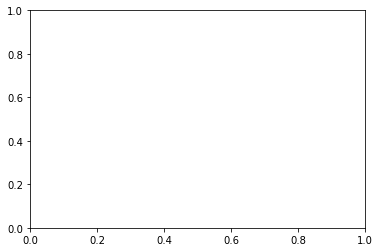

In [10]:
# Define the plot_band_array function from Day 1
def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='spectral'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

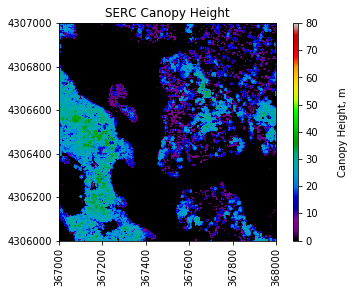

In [11]:
plot_band_array(chm_array,chm_ext,(0,80),title='SERC Canopy Height',cmap_title='Canopy Height, m')

### Plot Histogram of Data 

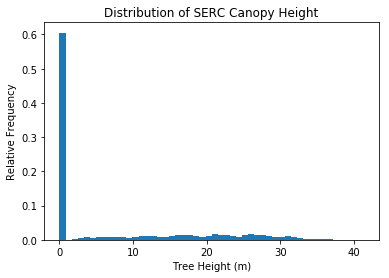

In [12]:
import copy
chm_nonan_array = copy.copy(chm_array)
chm_nonan_array = chm_nonan_array[~np.isnan(chm_array)]
plt.hist(chm_nonan_array,weights=np.zeros_like(chm_nonan_array)+1./
         (chm_array.shape[0]*chm_array.shape[1]),bins=50);
plt.title('Distribution of SERC Canopy Height')
plt.xlabel('Tree Height (m)'); plt.ylabel('Relative Frequency')

We can see that most of the values are zero. In SERC, many of the zero CHM values correspond to bodies of water as well as regions of land without trees. Let's look at a  histogram and plot the data without zero values: 

min: 2.0 m
max: 41.31 m
mean: 19.23 m


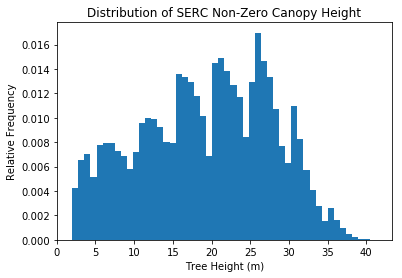

In [13]:
chm_nonzero_array = copy.copy(chm_array)
chm_nonzero_array[chm_array==0]=np.nan
chm_nonzero_nonan_array = chm_nonzero_array[~np.isnan(chm_nonzero_array)]
# Use weighting to plot relative frequency
plt.hist(chm_nonzero_nonan_array,weights=np.zeros_like(chm_nonzero_nonan_array)+1./
         (chm_array.shape[0]*chm_array.shape[1]),bins=50);

# plt.hist(chm_nonzero_nonan_array.flatten(),50) 
plt.title('Distribution of SERC Non-Zero Canopy Height')
plt.xlabel('Tree Height (m)'); plt.ylabel('Relative Frequency')
# plt.xlim(0,25); plt.ylim(0,4000000)

print('min:',np.amin(chm_nonzero_nonan_array),'m')
print('max:',round(np.amax(chm_nonzero_nonan_array),2),'m')
print('mean:',round(np.mean(chm_nonzero_nonan_array),2),'m')

From the histogram we can see that the majority of the trees are < 45m. We can replot the CHM array, this time adjusting the color bar to better visualize the variation in canopy height. We will plot the non-zero array so that CHM=0 appears white. 

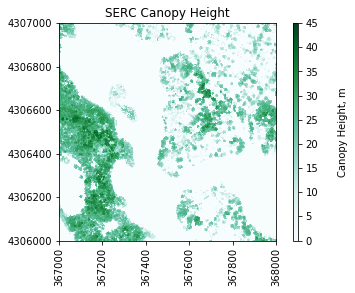

In [14]:
plot_band_array(chm_array,chm_ext,(0,45),title='SERC Canopy Height',cmap_title='Canopy Height, m',colormap='BuGn')

### Create a ```raster2array``` function to automate conversion of Geotif to array:

Now that we have a basic understanding of how GDAL reads in a Geotif file, we can write a function to read in a NEON geotif, convert it to a numpy array, and store the associated metadata in a Python dictionary in order to more efficiently carry out further analysis:

In [15]:
# raster2array.py reads in the first band of geotif file and returns an array and associated 
# metadata dictionary containing ...

from osgeo import gdal
import numpy as np

def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [16]:
SERC_chm_array, SERC_chm_metadata = raster2array('../data/SERC/lidar/SERC_CHM.tif')

print('SERC CHM Array:\n',SERC_chm_array)

#print metadata in alphabetical order
for item in sorted(SERC_chm_metadata):
    print(item + ':', SERC_chm_metadata[item])

SERC CHM Array:
 [[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]
array_cols: 11197
array_rows: 14997
bands: 1
bandstats: {'mean': 10.66, 'max': 48.45, 'stdev': 12.54, 'min': 0.0}
driver: GeoTIFF
ext_dict: {'xMin': 358816.0, 'xMax': 370013.0, 'yMax': 4313476.0, 'yMin': 4298479.0}
extent: (358816.0, 370013.0, 4298479.0, 4313476.0)
geotransform: (358816.0, 1.0, 0.0, 4313476.0, 0.0, -1.0)
noDataValue: -9999.0
pixelHeight: -1.0
pixelWidth: 1.0
projection: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_

## Threshold Based Raster Classification
Next, we will create a classified raster object. To do this, we will use the se the numpy.where function to create a new raster based off boolean classifications. Let's classify the canopy height into four groups:
- Class 1: **CHM = 0 m** 
- Class 2: **0m < CHM <= 20m**
- Class 3: **20m < CHM <= 40m**
- Class 4: **CHM > 40m**

Min: 1.0
Max: 4.0
Mean: 1.59


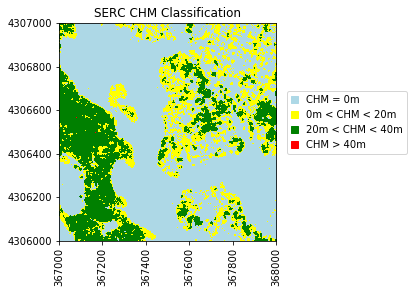

In [17]:
chm_reclass = copy.copy(chm_array)
chm_reclass[np.where(chm_array==0)] = 1 # CHM = 0 : Class 1
chm_reclass[np.where((chm_array>0) & (chm_array<=20))] = 2 # 0m < CHM <= 20m - Class 2
chm_reclass[np.where((chm_array>20) & (chm_array<=40))] = 3 # 20m < CHM < 40m - Class 3
chm_reclass[np.where(chm_array>40)] = 4 # CHM > 40m - Class 4

print('Min:',np.nanmin(chm_reclass))
print('Max:',np.nanmax(chm_reclass))
print('Mean:',round(np.nanmean(chm_reclass),2))

import matplotlib.colors as colors
plt.figure(); #ax = plt.subplots()
cmapCHM = colors.ListedColormap(['lightblue','yellow','green','red'])
plt.imshow(chm_reclass,extent=chm_ext,cmap=cmapCHM)
plt.title('SERC CHM Classification')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
# forceAspect(ax,aspect=1) # ax.set_aspect('auto')

# Create custom legend to label the four canopy height classes:
import matplotlib.patches as mpatches
class1_box = mpatches.Patch(color='lightblue', label='CHM = 0m')
class2_box = mpatches.Patch(color='yellow', label='0m < CHM < 20m')
class3_box = mpatches.Patch(color='green', label='20m < CHM < 40m')
class4_box = mpatches.Patch(color='red', label='CHM > 40m')

ax.legend(handles=[class1_box,class2_box,class3_box,class4_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)

## Challenge 1: Document Your Workflow 
1. Look at the code that you created for this lesson. Now imagine yourself months in the future. Document your script so that your methods and process is clear and reproducible for yourself or others to follow in the future. 
2. In documenting your script, synthesize the outputs. Do they tell you anything about the vegetation structure at the field site? 

## Challenge 2: Try out other Classifications
Create the following threshold classified outputs:
1. A raster where NDVI values are classified into the following categories:
    * Low greenness: NDVI < 0.3
    * Medium greenness: 0.3 < NDVI < 0.6
    * High greenness: NDVI > 0.6
2. A raster where aspect is classified into North and South facing slopes: 

Be sure to document your workflow as you go using Jupyter Markdown cells. When you are finished, explore your outputs to HTML  by selecting File > Download As > HTML (.html). Save the file as LastName_Tues_classifyThreshold.html. Add this to the Tuesday directory in your DI17-NEON-participants Git directory and push them to your fork in GitHub. Merge with the central repository using a pull request. 

## Aspect Raster Classification on TEAK Dataset (California)

Next, we will create a classified raster object based on slope using the TEAK dataset. This time, our classifications will be:
- **North Facing Slopes**: 0-45 & 315-360 degrees ; class=1
- **South Facing Slopes**: 135-225 degrees ; class=2
- **East & West Facing Slopes**: 45-135 & 225-315 degrees ; unclassified

<p>
<img src="files/NSEW_Classification.jpg" style="width: 250px;"/>
<center><font size="2">Figure: (Boz et al. 2015)</font></center>
<center><font size="2">http://www.aimspress.com/article/10.3934/energy.2015.3.401/fulltext.html</font></center>
</p>

**Further Reading:** There are a range of applications for aspect classificaiton. The link above shows an example of classifying LiDAR aspect data to determine suitability of roofs for PV (photovoltaic) systems. Can you think of any other applications where aspect classification might be useful?

**Data Tip:** You can calculate aspect in Python from a digital elevation (or surface) model using the pyDEM package: https://earthlab.github.io/tutorials/get-slope-aspect-from-digital-elevation-model/

**Let's get started.** First we can import the TEAK aspect raster geotif and convert it to an array using the ```raster2array``` function:

In [18]:
TEAK_aspect_tif = '../data/TEAK/lidar/2013_TEAK_1_326000_4103000_DTM_aspect.tif'
TEAK_asp_array, TEAK_asp_metadata = raster2array(TEAK_aspect_tif)
print('TEAK Aspect Array:\n',TEAK_asp_array)

#print metadata in alphabetical order
for item in sorted(TEAK_asp_metadata):
    print(item + ':', TEAK_asp_metadata[item])

plot_band_array(TEAK_asp_array,TEAK_asp_metadata['extent'],'TEAK Aspect','Aspect, degrees')

TEAK Aspect Array:
 [[  57.15999985   62.50999832   65.08999634 ...,  181.94999695
   186.82000732  188.80999756]
 [  57.99000168   65.77999878   70.5        ...,  182.96000671
   187.66000366  188.80999756]
 [  57.36000061   65.19999695   70.23999786 ...,  183.80999756
   188.00999451  188.53999329]
 ..., 
 [ 271.51998901  274.27999878  283.25       ...,  132.80000305
   119.55000305  109.        ]
 [ 265.73001099  279.27999878  322.32000732 ...,  135.53999329
   127.58999634  118.41000366]
 [ 255.38999939  259.70001221  281.70001221 ...,  125.73000336
   127.26999664  125.08000183]]
array_cols: 1000
array_rows: 1000
bands: 1
bandstats: {'mean': 115.59, 'max': 359.99, 'stdev': 66.57, 'min': 0.0}
driver: GeoTIFF
ext_dict: {'xMin': 326000.0, 'xMax': 327000.0, 'yMax': 4104000.0, 'yMin': 4103000.0}
extent: (326000.0, 327000.0, 4103000.0, 4104000.0)
geotransform: (326000.0, 1.0, 0.0, 4104000.0, 0.0, -1.0)
noDataValue: -9999.0
pixelHeight: -1.0
pixelWidth: 1.0
projection: PROJCS["WGS 84 / U

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

TypeError: iteration over a 0-d array

Min: 1.0
Max: 2.0
Mean: 1.7


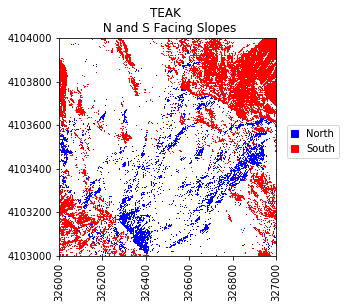

In [19]:
aspect_array = copy.copy(TEAK_asp_array)
asp_reclass = copy.copy(aspect_array)
asp_reclass[np.where(((aspect_array>=0) & (aspect_array<=45)) | (aspect_array>=315))] = 1 #North - Class 1
asp_reclass[np.where((aspect_array>=135) & (aspect_array<=225))] = 2 #South - Class 2
asp_reclass[np.where(((aspect_array>45) & (aspect_array<135)) | ((aspect_array>225) & (aspect_array<315)))] = np.nan #W & E - Unclassified

print('Min:',np.nanmin(asp_reclass))
print('Max:',np.nanmax(asp_reclass))
print('Mean:',round(np.nanmean(asp_reclass),2))

# Scale plot 
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

# plot_band_array(aspect_reclassified,asp_ext,'North and South Facing Slopes \n TEAK')
from matplotlib import colors
fig, ax = plt.subplots()
cmapNS = colors.ListedColormap(['blue','red'])
plt.imshow(asp_reclass,extent=TEAK_asp_metadata['extent'],cmap=cmapNS)
plt.title('TEAK \n N and S Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
ax = plt.gca(); forceAspect(ax,aspect=1)

# Create custom legend to label N & S
import matplotlib.patches as mpatches
blue_box = mpatches.Patch(color='blue', label='North')
red_box = mpatches.Patch(color='red', label='South')
ax.legend(handles=[blue_box,red_box],handlelength=0.7,bbox_to_anchor=(1.05, 0.45), 
          loc='lower left', borderaxespad=0.)

## References 

Bayrakci Boz, M.; Calvert, K.; Brownson, J.R.S. An automated model for rooftop PV systems assessment in ArcGIS using LIDAR. AIMS Energy 2015, 3, 401–420.